In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


# How to load pandas data

In [2]:
import pandas as pd

In [5]:
df = pd.read_csv('../data/voting_with_coords.csv', header=None)

In [6]:
df.head()

,0,1,2,3,4
0,name,ra,dec,quality,quality_category
1,2512_19_0_line5956,115.5917605,64.642662554,2,2
2,2191_1_0_line11382__EON_181.762_40.200,181.7619258725,40.199905715250004,2,1
3,798_36_0_line562,7.8151236543,-22.5596903875,3,2
4,1892_86_1_line12354,192.58292245,27.323999067,2,1


In [7]:
df.shape

(1926, 5)

# Legacy fits loading

Можно посмотреть картинки на https://www.legacysurvey.org/viewer, справа есть вкладка также с моделями и остатками, и предыдущим резизом DR8.

In [10]:
import numpy as np
import os
import urllib

In [11]:
def geturl_legacy(ra, dec, size=240, band='r', layer='dr8-resid'):
    
    assert band in ['g', 'r', 'z']
    assert layer in ['dr8', 'dr8-resid', 'dr8-model']

    url = ("http://legacysurvey.org/viewer/fits-cutout/?ra={}&dec={}&layer={}&pixscale=0.27&bands={}&size={}").format(ra, dec, layer, band, size)
    return url

In [12]:
def clear_on_fail_(name, dir_path):
    for band in ['g', 'r', 'z']:
        for layer in ['dr8', 'dr8-resid', 'dr8-model']:
            output_image='{}/{}_{}_{}.fits'.format(dir_path, name, layer, band)
            try:
                os.remove(output_image)
            except:
                pass

def load_legacy_all(name=None, ra=None, dec=None, size=None, save_to=None):
    if not os.path.isdir(save_to):
        os.mkdir(save_to)
    
    for band in ['g', 'r', 'z']:
        for layer in ['dr8', 'dr8-resid', 'dr8-model']:
            try:
                fitsurl = geturl_legacy(ra, dec, band=band, size=size, layer=layer)
                output_image='{}/{}_{}_{}.fits'.format(save_to, name, layer, band)
                urllib.request.urlretrieve(fitsurl, output_image)
                if os.path.getsize(output_image)/1024 < 3:  # empirical threshold
                    clear_on_fail_(name, save_to)
                    break;break
            except Exception as e:
                clear_on_fail_(name, save_to)
                raise e

Example:

In [14]:
%%time
load_legacy_all(name='1353_35_0_line6550', ra=123.7185078325, dec=1.5649554293, size=400, save_to='../data/test_fits/')

CPU times: user 70.1 ms, sys: 64.8 ms, total: 135 ms
Wall time: 26.9 s


**Проблема с `size` - непонятно, какой брать. Можно побольше и потом обрезать. Можно его, как и поворот, определить с помощью https://photutils.readthedocs.io/en/stable/segmentation.html**

Еще хорошо бы использовать последний релиз, DR9, надо посмотреть что изменилось в ссылке на скачивание.

# Rotate and zoom in python

In [24]:
import pyfits
from scipy.ndimage import rotate
from astropy.visualization import ZScaleInterval, PercentileInterval

In [39]:
hdulist = pyfits.open('../data/test_fits/1353_35_0_line6550_dr8_z.fits')
img_header = hdulist[0].header
img_data_raw = hdulist[0].data

reshape добавит нулей вокруг, если диск не обрезался после поворота - то это не нужно.

In [37]:
rot_im = rotate(img_data_raw, angle=22.5, reshape=False)

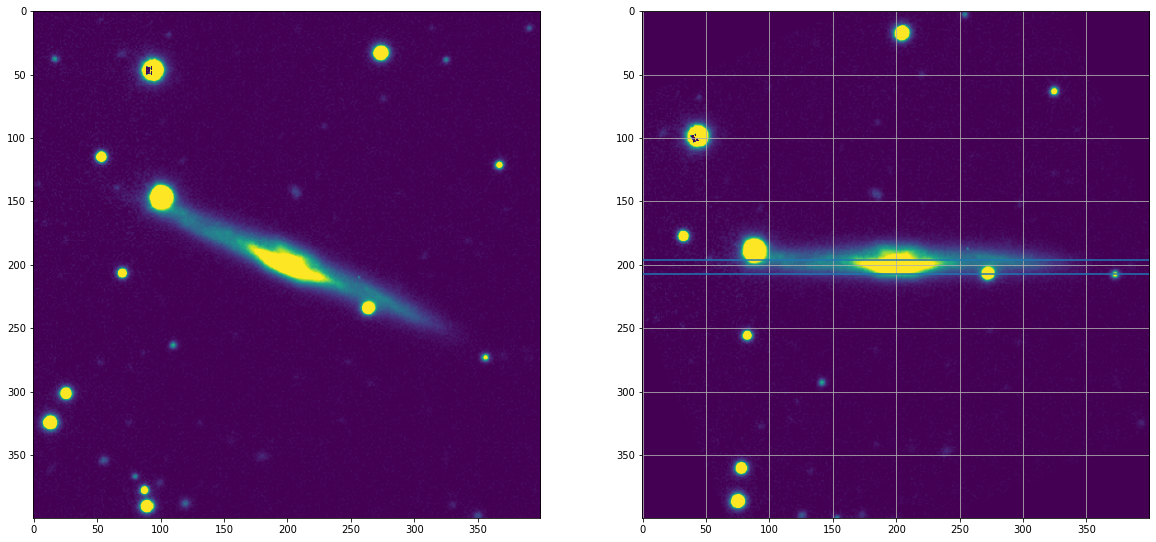

In [20]:
fig = plt.figure(figsize=[20,10])
plt.subplot(121)
plt.imshow(img_data_raw, vmin=0, vmax=0.3)
plt.subplot(122)
plt.imshow(rot_im, vmin=0, vmax=0.3)
plt.grid()
plt.axhline(y=207)
plt.axhline(y=196)
plt.show()

hdu = pyfits.PrimaryHDU(data=rot_im)
hdu.writeto('../data/test_fits/rotated_z.fits')

Было-стало. 

Хорошо проверять на глаз поворот так: рисуем горизонтальные линии близко к центру и смотрим, одинаково ли они пересекают изофоты.

Картинку надо обрезать, чтобы убрать все лишнее вокруг:

In [41]:
hdulist = pyfits.open('../data/test_fits/rotated_z.fits')
data = hdulist[0].data

data = data[150:250, 45:350]

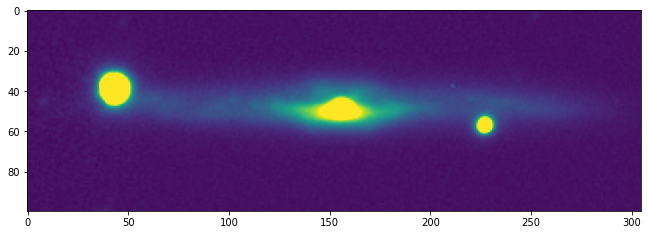

In [28]:
fig = plt.figure(figsize=[11,6])
ax = plt.gca()
plt.imshow(data, vmax=0.6)
lims = ZScaleInterval().get_limits(data)
plt.show()

Обязательно сохраните обрезанный фитс в отдельный файл, скажем `name_rotated_cropped_band.fits`

# Iso and colour pictures

/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log2
  """
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log2
  
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log2
  import sys


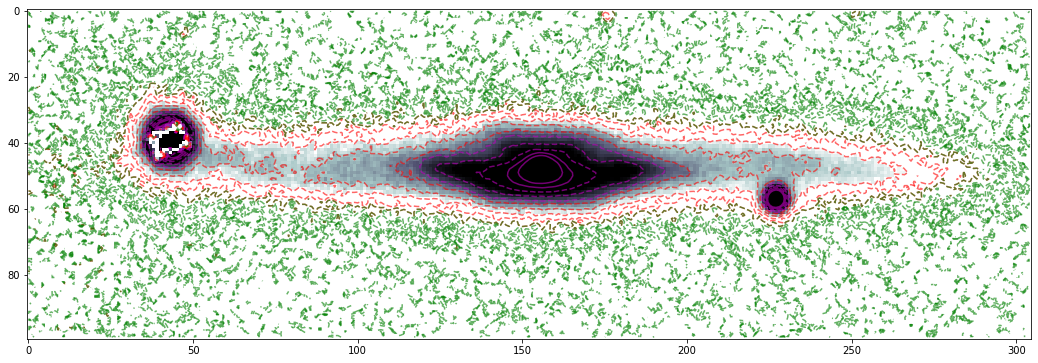

In [42]:
fig = plt.figure(figsize=[18,9])
ax = plt.gca()
plt.imshow(np.log2(data), cmap=cm.bone_r, vmin=-3, vmax=-0.5)
# lims = ZScaleInterval().get_limits(data)
ax.contour(np.log2(data), levels=np.linspace(np.log2(0.4), np.log2(1.8), 5), colors='m', alpha=0.6)
ax.contour(np.log2(data), levels=np.linspace(np.log2(0.05), np.log2(0.3), 5), colors='r', alpha=0.6)
ax.contour(np.log2(data), levels=np.linspace(np.log2(0.005), np.log2(0.05), 5), colors='g', alpha=0.6)
plt.show()

Как подбирать конкретные изофоты, чтоб они хорошо покрывали, в общем случае не ясно. Поэкспериментируйте с ZScaleInterval или еще с чем-то. Главное, чтоб хорошо была видна внутреняя структура.

Картинка с цветами *g-r*:

In [43]:
hdulist = pyfits.open('../data/test_fits/rotated_g.fits')
data = hdulist[0].data
data_g = 22.5 - 2.5*np.log10(data[150:250, 75:320])

hdulist = pyfits.open('../data/test_fits/rotated_r.fits')
data = hdulist[0].data
data_r = 22.5 - 2.5*np.log10(data[150:250, 75:320])

magcolour = data_g - data_r

/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


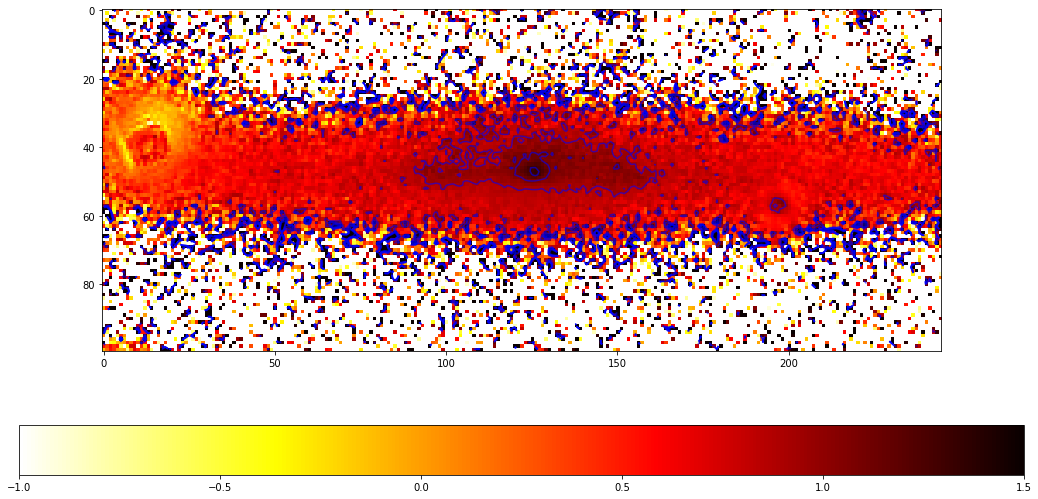

In [44]:
fig = plt.figure(figsize=[18,9])
ax = plt.gca()
im=plt.imshow(magcolour, cmap=cm.hot_r, vmin=-1, vmax=1.5)
fig.colorbar(im, orientation='horizontal')
# ax.contour(magcolour[::-1,:], levels=np.linspace(0.8, 0.9, 3), colors='g', alpha=0.6)
ax.contour(magcolour, levels=np.linspace(0.9, 1.7, 5), colors='b', alpha=0.6)
# ax.contour(magcolour[::-1,:], levels=np.linspace(0.005, 0.05, 5), colors='g', alpha=0.6)
plt.show()

Картинки надо будет нарисовать для всех полос, а картинку с цветами - только одну.

Сохранить отдельно, может быть объединить для одной галактики в коллаж.